# Execução do modelo e Streamlit

Este notebook detalha a execução do projeto, incluindo análise exploratória,
treinamento e atualização dos relatórios. A base traduzida em PT-BR é salva
em `data/processed/base_traduzida_ptbr.csv`.


## Bibliotecas


In [1]:
import json
import os
import subprocess
import sys
import time
import webbrowser
from pathlib import Path

def encontrar_raiz():
    atual = Path.cwd()
    for _ in range(4):
        if (atual / "Predicao.py").exists() and (atual / "src").exists():
            return atual
        if atual.parent == atual:
            break
        atual = atual.parent
    return Path.cwd()

raiz_projeto = encontrar_raiz()
os.chdir(raiz_projeto)
if str(raiz_projeto) not in sys.path:
    sys.path.insert(0, str(raiz_projeto))
print(f"Diretório de trabalho: {Path.cwd()}")

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from joblib import load
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from src.obesity_tc.make_dataset import preprocessar_base, salvar_base_ptbr, traduzir_ptbr
from src.obesity_tc.train import MAPA_NIVEL_OBESIDADE


Diretório de trabalho: c:\Users\murilo.santos\Documents\tech4challenge\obesity_tc_project


## 1) Preparação do ambiente
Define o diretório raiz para que os caminhos relativos funcionem.


In [2]:
# Diretório definido na célula de bibliotecas.
print(f"Diretório de trabalho: {Path.cwd()}")


Diretório de trabalho: c:\Users\murilo.santos\Documents\tech4challenge\obesity_tc_project


## 2) Configuração da execução
Ajuste os parâmetros de dados, modelo e split de treino/teste.


In [3]:
config = {
    "data_path": "data/raw/Obesity.csv",
    "target": "Obesity",
    "model_out": "models/modelo_obesidade.joblib",
    "test_size": 0.2,
    "random_state": 42,
    "min_accuracy": 0.75,
}
config


{'data_path': 'data/raw/Obesity.csv',
 'target': 'Obesity',
 'model_out': 'models/modelo_obesidade.joblib',
 'test_size': 0.2,
 'random_state': 42,
 'min_accuracy': 0.75}

## 3) Análise exploratória dos dados
Explora a base atual para entender distribuições, classes e correlações.


Base bruta: 2111 linhas x 17 colunas


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Base tratada (PT-BR): 2111 linhas x 18 colunas


,Gênero,Idade,Altura (m),Peso (kg),Histórico familiar de sobrepeso,Alimentos hipercalóricos frequentes,Consumo de vegetais,Refeições principais,Beliscar entre refeições,Fuma,Consumo de água,Monitoramento de calorias,Atividade física,Tempo usando tecnologia,Consumo de álcool,Meio de transporte,Nível de obesidade,IMC
0,Feminino,21.0,1.62,64.0,Sim,Não,2,3,às vezes,Não,2,Não,0,1,não,Transporte público,Peso normal,24.386526
1,Feminino,21.0,1.52,56.0,Sim,Não,3,3,às vezes,Sim,3,Sim,3,0,às vezes,Transporte público,Peso normal,24.238227
2,Masculino,23.0,1.80,77.0,Sim,Não,2,3,às vezes,Não,2,Não,2,1,frequentemente,Transporte público,Peso normal,23.765432
3,Masculino,27.0,1.80,87.0,Não,Não,3,3,às vezes,Não,2,Não,2,0,frequentemente,Caminhada,Sobrepeso nível I,26.851852
4,Masculino,22.0,1.78,89.8,Não,Não,2,1,às vezes,Não,2,Não,0,0,às vezes,Transporte público,Sobrepeso nível II,28.342381


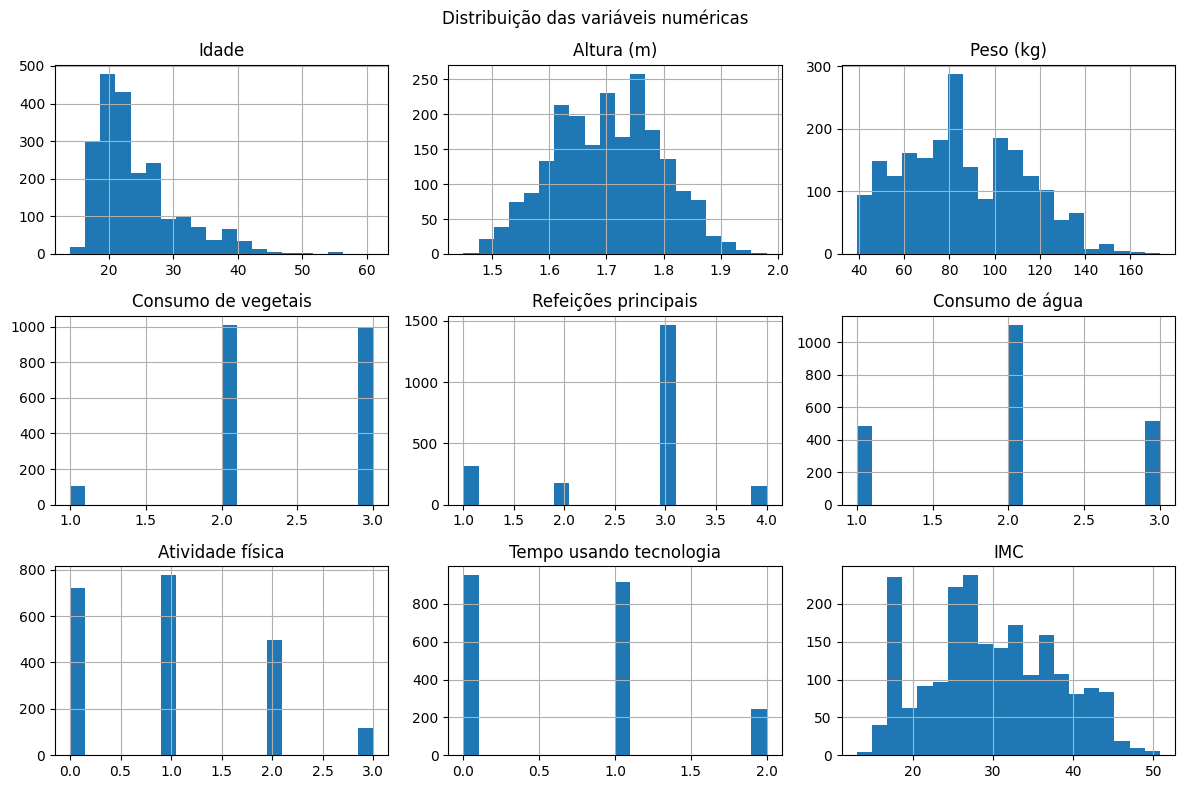

In [4]:
df_raw = pd.read_csv(config["data_path"])
print(f"Base bruta: {df_raw.shape[0]} linhas x {df_raw.shape[1]} colunas")
display(df_raw.head())

missing = df_raw.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
if not missing.empty:
    display(missing)

df = preprocessar_base(df_raw, coluna_alvo=config["target"])
salvar_base_ptbr(df)
df_pt = traduzir_ptbr(df)

print(f"Base tratada (PT-BR): {df_pt.shape[0]} linhas x {df_pt.shape[1]} colunas")
display(df_pt.head())

col_nivel = "Nível de obesidade"
if col_nivel in df_pt.columns:
    dist = df_pt[col_nivel].value_counts().reset_index()
    dist.columns = [col_nivel, "Quantidade"]
    fig = px.bar(
        dist,
        x=col_nivel,
        y="Quantidade",
        title="Distribuição do nível de obesidade",
    )
    fig.show()

num_cols = df_pt.select_dtypes(include="number").columns.tolist()
if num_cols:
    df_pt[num_cols].hist(figsize=(12, 8), bins=20)
    plt.suptitle("Distribuição das variáveis numéricas", fontsize=12)
    plt.tight_layout()
    plt.show()

if len(num_cols) >= 2:
    corr = df_pt[num_cols].corr(numeric_only=True)
    fig_corr = px.imshow(
        corr,
        text_auto=".2f",
        title="Correlação entre variáveis numéricas",
        color_continuous_scale="RdBu",
        zmin=-1,
        zmax=1,
    )
    fig_corr.show()


## 4) Treinamento do modelo
Executa o treino via `src.obesity_tc.train` e salva o modelo.


In [5]:
comando_treino = [
    sys.executable,
    "-m",
    "src.obesity_tc.train",
    "--data",
    config["data_path"],
    "--target",
    config["target"],
    "--model_out",
    config["model_out"],
    "--test_size",
    str(config["test_size"]),
    "--random_state",
    str(config["random_state"]),
    "--min_accuracy",
    str(config["min_accuracy"]),
]
subprocess.run(comando_treino, check=True)


CompletedProcess(args=['c:\\Users\\murilo.santos\\AppData\\Local\\Programs\\Python\\Python312\\python.exe', '-m', 'src.obesity_tc.train', '--data', 'data/raw/Obesity.csv', '--target', 'Obesity', '--model_out', 'models/modelo_obesidade.joblib', '--test_size', '0.2', '--random_state', '42', '--min_accuracy', '0.75'], returncode=0)

## 5) Atualização de métricas
Recalcula os relatórios com o modelo salvo e os dados atuais.


In [6]:
metrics_path = Path("reports/metrics.json")
report_path = Path("reports/classification_report.txt")

df_raw = pd.read_csv(config["data_path"])
df = preprocessar_base(df_raw, coluna_alvo=config["target"])

if "Obesity_level" not in df.columns:
    raise ValueError("Base sem a coluna Obesity_level para avaliação.")

y = df["Obesity_level"]
X = df.drop(columns=["Obesity_level"])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=config["test_size"],
    random_state=config["random_state"],
    stratify=y,
)

bundle = load(config["model_out"])
pred = bundle["pipeline"].predict(X_test)
acuracia = float(accuracy_score(y_test, pred))

classes_ordenadas = sorted(y.unique().tolist())
classes_pt = [MAPA_NIVEL_OBESIDADE.get(c, c) for c in classes_ordenadas]

metricas = {
    "acuracia": acuracia,
    "n_treino": int(len(X_train)),
    "n_teste": int(len(X_test)),
    "classes": classes_pt,
    "classes_original": classes_ordenadas,
    "matriz_confusao": confusion_matrix(
        y_test, pred, labels=classes_ordenadas
    ).tolist(),
}

metrics_path.parent.mkdir(parents=True, exist_ok=True)
metrics_path.write_text(
    json.dumps(metricas, indent=2, ensure_ascii=False), encoding="utf-8"
)

report_text = classification_report(
    y_test,
    pred,
    labels=classes_ordenadas,
    target_names=classes_pt,
    digits=4,
)
report_path.write_text(report_text, encoding="utf-8")

print(f"Relatórios atualizados: {metrics_path} e {report_path}")


Relatórios atualizados: reports\metrics.json e reports\classification_report.txt
